# Misc JPEG stuff

In [1]:
% matplotlib inline
from scipy.fftpack import dct, idct
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as plt_pe

In [2]:
def plot_im_and_numbers(im, dpi=100, vmin=None, vmax=None,
                        x_start=None, x_end=None, y_start=None, y_end=None,
                        fname=None):
    """Plot an image and display the intensity values on the pixel"""
    
    h, w = im.shape
    
    if vmin is None:
        vmin = np.min(im)
    if vmax is None:
        vmax = np.max(im)
    
    plt.figure(dpi=dpi)
    
    # Plot image
    plt.imshow(im, cmap='gray', interpolation='none', vmin=vmin, vmax=vmax)
    
    #if (x_start is None) or (x_end is None) or (y_start is None) or (y_end is None):
    #    plt.axis('off')
    #else:
    #    plt.yticks(range(0, x_end-x_start, 2), range(x_start, x_end, 2))
    #    plt.xticks(range(0, y_end-y_start, 2), range(y_start, y_end, 2))
    
    # Draw pixel values
    for x in range(h):
        for y in range(w):
            plt.annotate(str(im[x, y]), xy=(y, x), 
                         horizontalalignment='center',
                         verticalalignment='center',
                         color='white',
                         path_effects=[plt_pe.withStroke(linewidth=2, foreground='black')],
                         fontsize='x-small')
    
    # Draw grid between pixels
    #plt.xticks(np.arange(0, im.shape[1]))
    plt.xticks(np.arange(0.5, im.shape[1] + 0.5), [])
    #plt.xaxis().set_ticks([]) # Hide tick labels
    #plt.yticks(np.arange(0, im.shape[0]))
    plt.yticks(np.arange(0.5, im.shape[0] + 0.5), [])
    #plt.yaxis().set_ticks([]) # Hide tick labels
    #plt.grid(b=True, which='minor', linestyle='-', color='gray')
    plt.grid(True)
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', dpi=dpi, transparent=True)

## JPEG step visualizations

Let us first create a test block, and do (some of) the JPEG steps on this block. We will use scipy's `dct()` twice to achieve a 2D DCT.

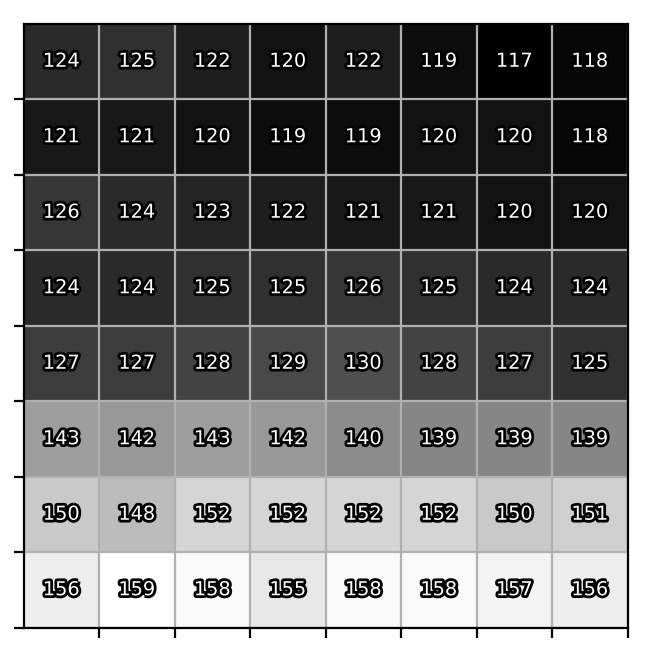

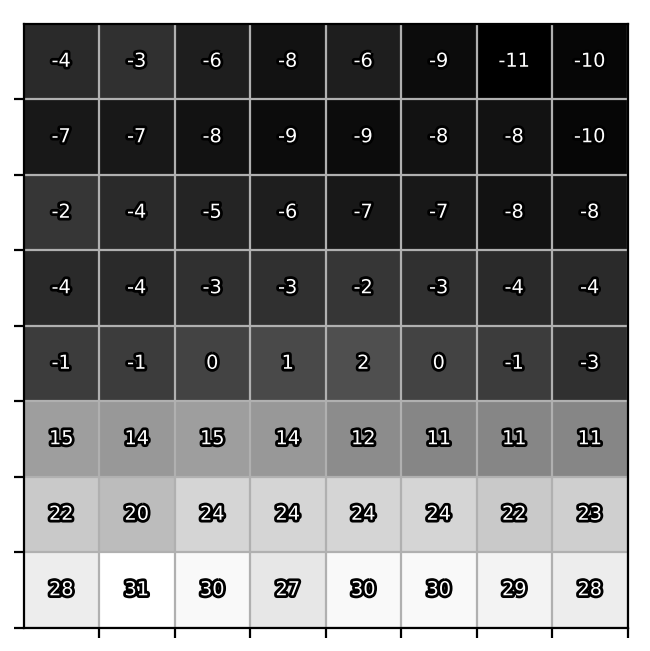

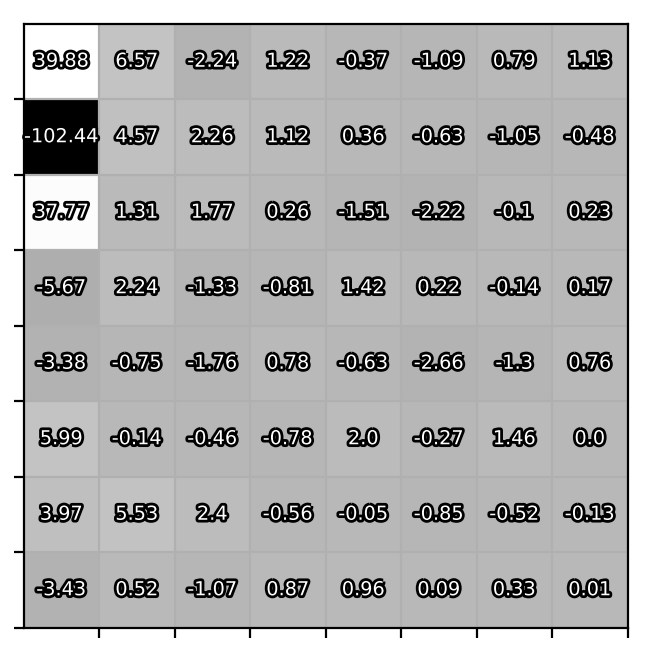

In [3]:
block = np.array([[124, 125, 122, 120, 122, 119, 117, 118],
                  [121, 121, 120, 119, 119, 120, 120, 118],
                  [126, 124, 123, 122, 121, 121, 120, 120],
                  [124, 124, 125, 125, 126, 125, 124, 124],
                  [127, 127, 128, 129, 130, 128, 127, 125],
                  [143, 142, 143, 142, 140, 139, 139, 139],
                  [150, 148, 152, 152, 152, 152, 150, 151],
                  [156, 159, 158, 155, 158, 158, 157, 156]])
block_sub = block - 128

# 2D discrete cosinus transform

block_dct = dct(dct(block_sub, axis=0, norm='ortho'), axis=1, norm='ortho')

plot_im_and_numbers(block, dpi=200, fname='assets/images/block.png')
plot_im_and_numbers(block_sub, dpi=200, fname='assets/images/block_sub.png')
plot_im_and_numbers(np.around(block_dct, decimals=2), dpi=200, fname='assets/images/block_dct.png')

Then, the loss of information takes place. We divide each element in the block by some value from a quantization matrix $Q$, we round the resulting value to the nearest integer, and multiply this result with $Q$.

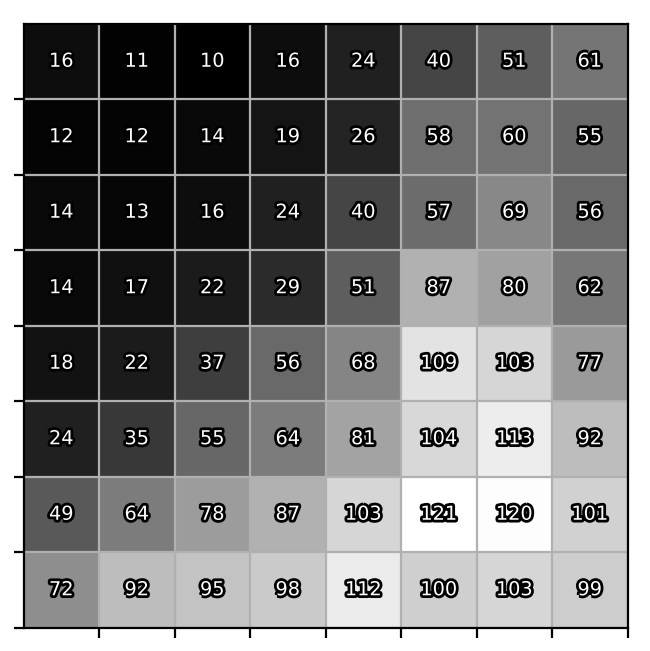

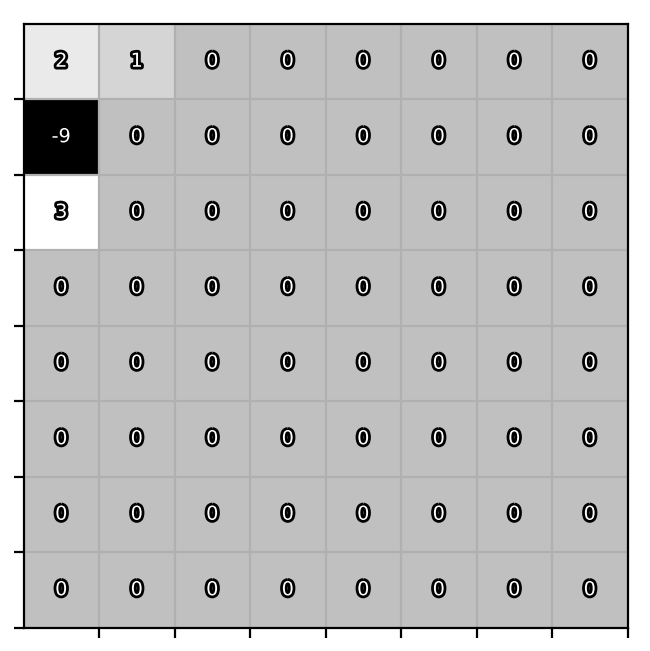

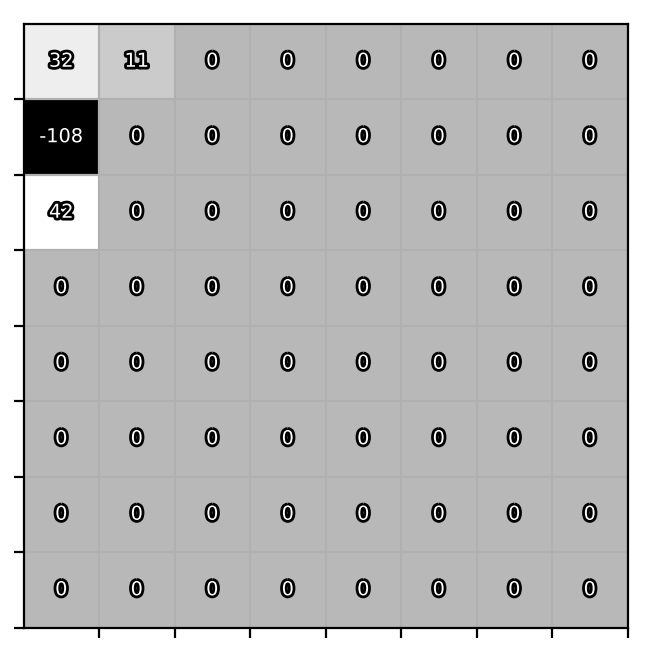

In [4]:
# Quantization matrix
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 103, 99]])

block_dct_quant = np.round(block_dct / Q).astype(int)
restored_dct = block_dct_quant * Q
plot_im_and_numbers(Q, dpi=200, fname='assets/images/block_quant.png')
plot_im_and_numbers(block_dct_quant, dpi=200, fname='assets/images/block_dct_quant.png')
plot_im_and_numbers(restored_dct, dpi=200, fname='assets/images/block_restored_dct.png')

This leaves us with a sparse frequency-domain representation that can be compressed more than the dense original frequency-domain representation. This is used to restore the original spatial-domain image, which is similar to the original, but not equal.

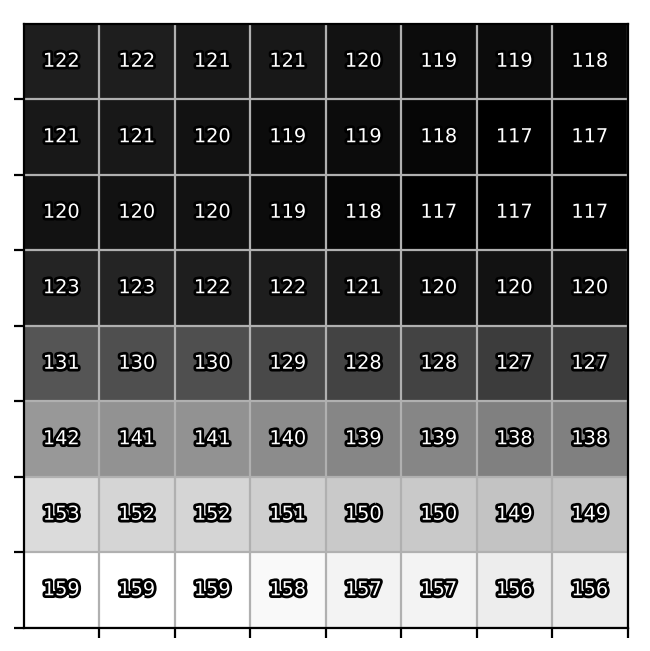

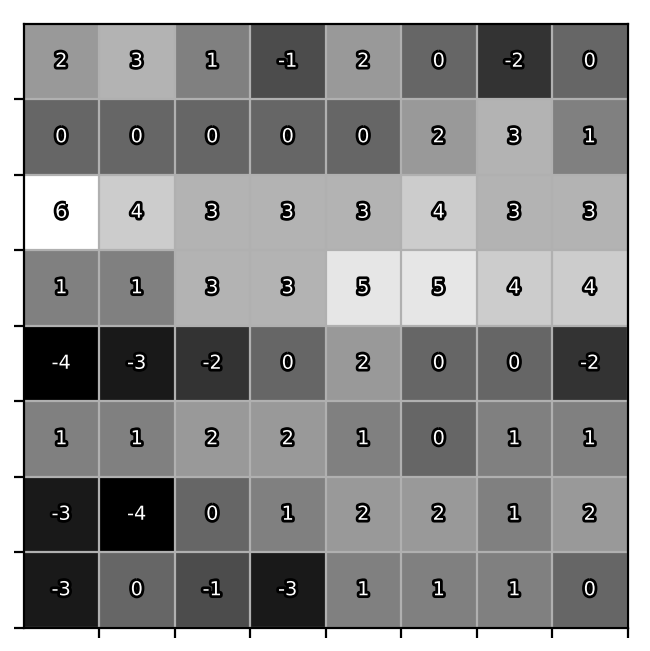

In [5]:
restored_temp = idct(idct(restored_dct, axis=0, norm='ortho'), axis=1, norm='ortho')
restored = np.round(restored_temp + 128).astype(np.uint8)
restored_diff = block - restored
plot_im_and_numbers(restored, dpi=200, fname='assets/images/block_restored.png')
plot_im_and_numbers(restored_diff, dpi=200, fname='assets/images/block_restored_diff.png')

## Cosine blocks

The 2D cosinus transform of an $m\times n$ image $f$ is

$$
F(u, v) = \frac{2}{\sqrt{mn}}c(u)c(v)\sum_{x = 0}^m\sum_{y = 0}^n f(x, y)
    \cos\left(\frac{(2x + 1)u\pi}{2m}\right) \cos\left(\frac{(2y + 1)v\pi}{2n}\right),
$$

where

$$
c(a) =
  \begin{cases}
    \frac{1}{\sqrt{2}} \quad &\text{if } a = 0, \\
    1                        &\text{otherwise.}
  \end{cases}
$$

In JPEG-compression, we transform patches of $8\times 8$ pixels at a time ($m = 8, n = 8$). Therefore we can reuse the cosine-parts, and save computation time by computing them once at the start. In this script I will try to illustrate the resulting 64 (from $u \in \{0, ..., 7\}, v \in \{0, ..., 7\}$) $8\times 8$ (from $x \in \{0, ..., 7\}, y \in \{0, ..., 7\}$) "cosine images".

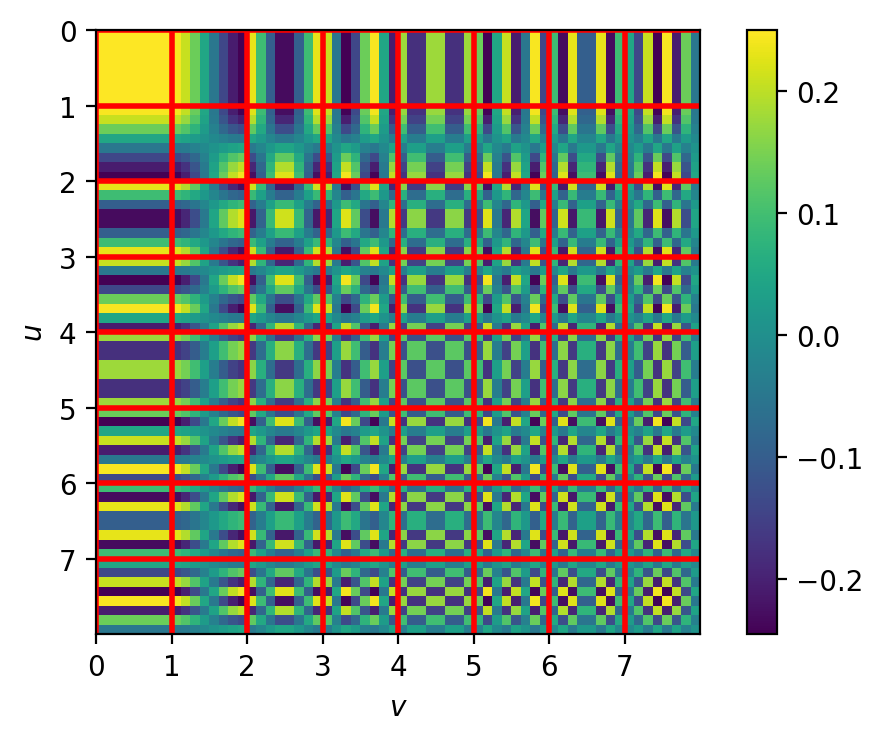

In [6]:
cosine_im = np.zeros((8*8, 8*8))

u_label = []
v_label = []
m = 8
n = 8
for u in range(8):
    for v in range(8):
        for x in range(8):
            for y in range(8):
                cosine_im[u*8 + x, v*8 + y] = 2*(np.cos((2*x + 1)*u*np.pi/(2*m))*
                                                 np.cos((2*y + 1)*v*np.pi/(2*n)))/np.sqrt(m*n)

plt.figure(dpi=200)
plt.imshow(cosine_im, interpolation='none')
plt.xticks(np.arange(0, 64, 8)-0.5, np.arange(0, 8))
plt.yticks(np.arange(0, 64, 8)-0.5, np.arange(0, 8))
plt.xlabel(r'$v$')
plt.ylabel(r'$u$')
plt.grid(True, color='red', linewidth=2)
plt.colorbar()
plt.savefig('assets/images/cosine_part.png', bbox_inches='tight', transparent=True)

## Encode and decode JPEG

Original size: 256.0 kiB


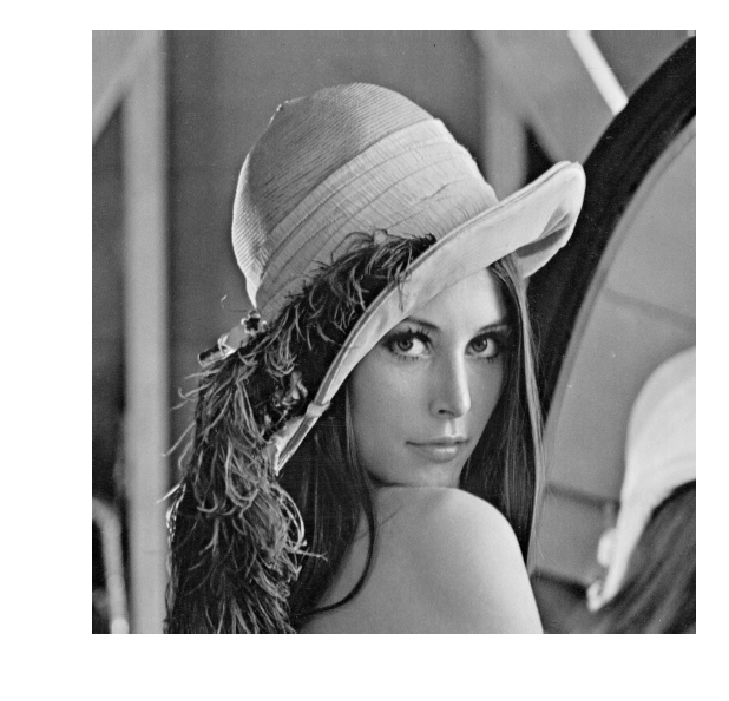

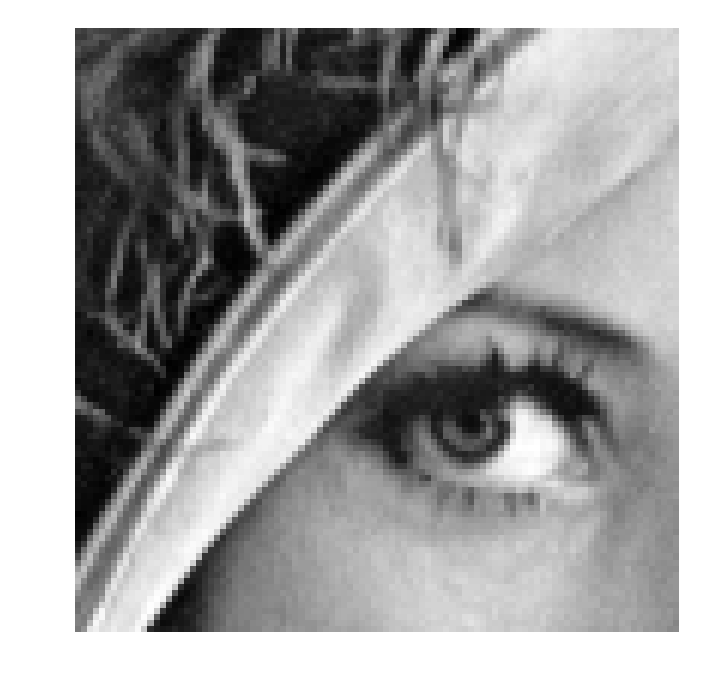

In [50]:
import cv2

orig_im = cv2.imread('assets/images/lena.png', cv2.IMREAD_GRAYSCALE)
h, w = orig_im.shape
b_per_pixel = 8
b_per_B = 8
B_per_kiB = 1024

orig_size_b = b_per_pixel * h * w

print('Original size: {} kiB'.format(orig_size_b/b_per_B/B_per_kiB))

plt.figure(0, dpi=200)
plt.imshow(orig_im, cmap='gray')
plt.axis('off')
plt.savefig('assets/images/lena_orig.png', bbox_inches='tight', transparent=True)

plt.figure(1, dpi=200)
plt.imshow(orig_im[200:300, 200:300], cmap='gray')
plt.axis('off')
plt.savefig('assets/images/lena_detail.png', bbox_inches='tight', transparent=True)

JPEG encoded image
Buffer data type: uint8
Buffer shape: (20983, 1)
Buffer size: 20.49 kiB
Compression rate: 12.49


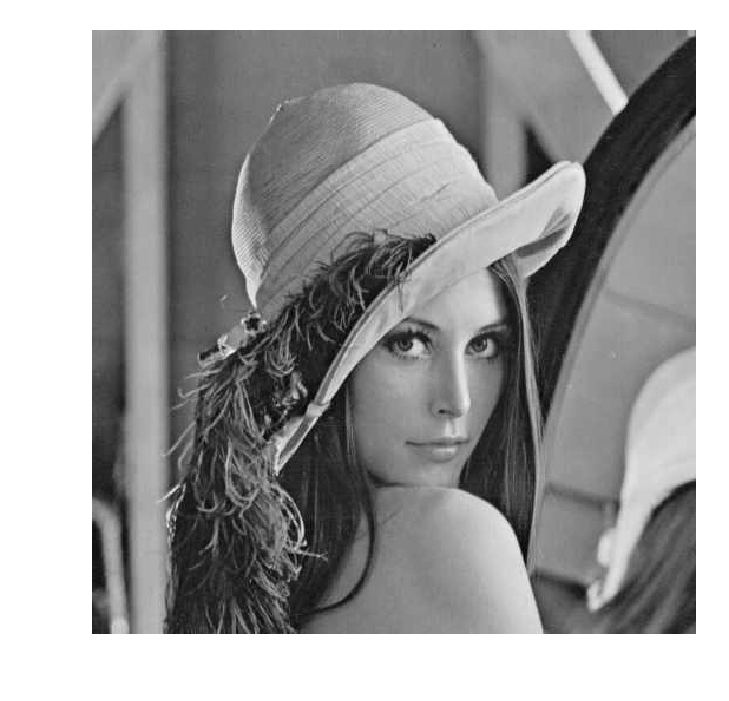

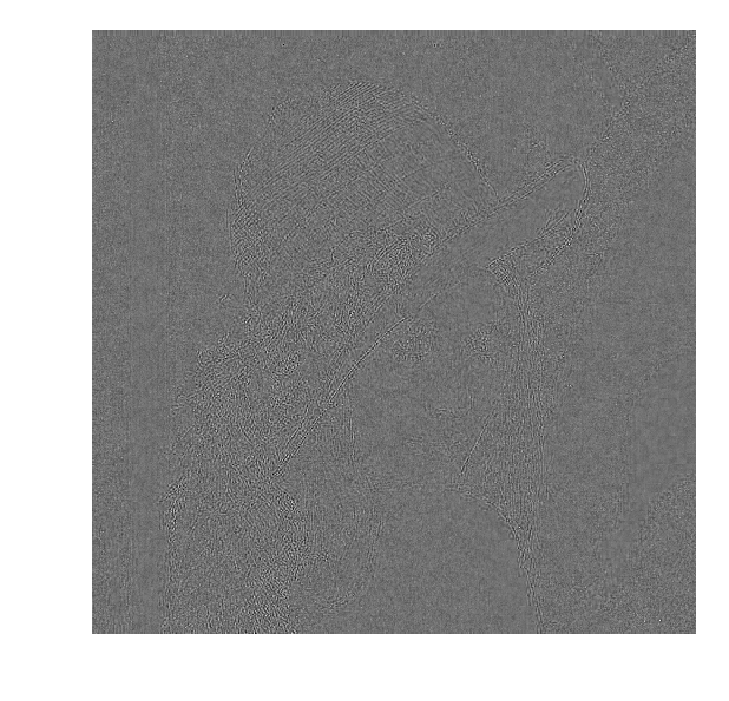

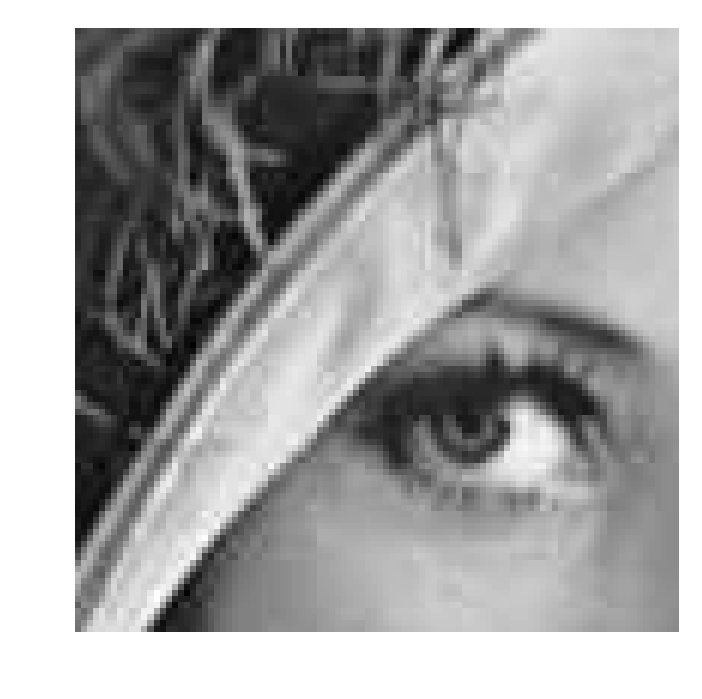

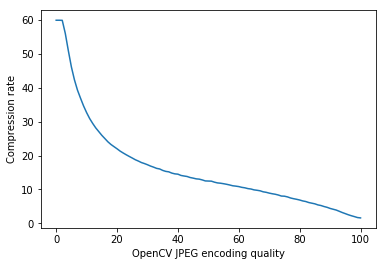

In [59]:
# JPEG
jpeg_quality = 50
_, encoded_im = cv2.imencode('.jpg', orig_im, (cv2.IMWRITE_JPEG_QUALITY, jpeg_quality))
decoded_im = cv2.imdecode(encoded_im, 0)

buf_size_b = encoded_im.shape[0] * 8 # uint8 data type in buffer

print('JPEG encoded image')
print('Buffer data type: {}'.format(encoded_im.dtype))
print('Buffer shape: {}'.format(encoded_im.shape))
print('Buffer size: {0:.2f} kiB'.format(buf_size_b/b_per_B/B_per_kiB))
print('Compression rate: {0:.2f}'.format(orig_size_b / buf_size_b))

plt.figure(0, dpi=200)
plt.imshow(decoded_im, cmap='gray')
plt.axis('off')
cv2.imwrite('assets/images/lena_compressed_{}.png'.format(jpeg_quality), decoded_im)

diff_im = orig_im.astype(int) - decoded_im.astype(int)
diff_im = 255*(diff_im - np.min(diff_im))/(np.max(diff_im) - np.min(diff_im))
plt.figure(1, dpi=200)
plt.imshow(diff_im, cmap='gray')
plt.axis('off')
cv2.imwrite('assets/images/lena_diff_{}.png'.format(jpeg_quality), diff_im)

plt.figure(2, dpi=200)
plt.imshow(decoded_im[200:300, 200:300], cmap='gray')
plt.axis('off')
cv2.imwrite('assets/images/lena_detail_{}.png'.format(jpeg_quality), decoded_im[200:300, 200:300])

# Display different compression rates
compression_rates = []
for jpeg_quality in range(0, 101):
    _, buf = cv2.imencode('.jpg', orig_im, (cv2.IMWRITE_JPEG_QUALITY, jpeg_quality))
    decoded_buf = cv2.imdecode(buf, 0)
    buf_size_b = buf.shape[0] * 8
    compression_rates.append(orig_size_b/buf_size_b)
    
plt.figure(3)
plt.plot(compression_rates)
plt.xlabel('OpenCV JPEG encoding quality')
plt.ylabel('Compression rate')

JPEG2000 encoded image
Buffer data type: uint8
Buffer shape: (141501, 1)
Compression rate: 1.85


(-0.5, 99.5, 99.5, -0.5)

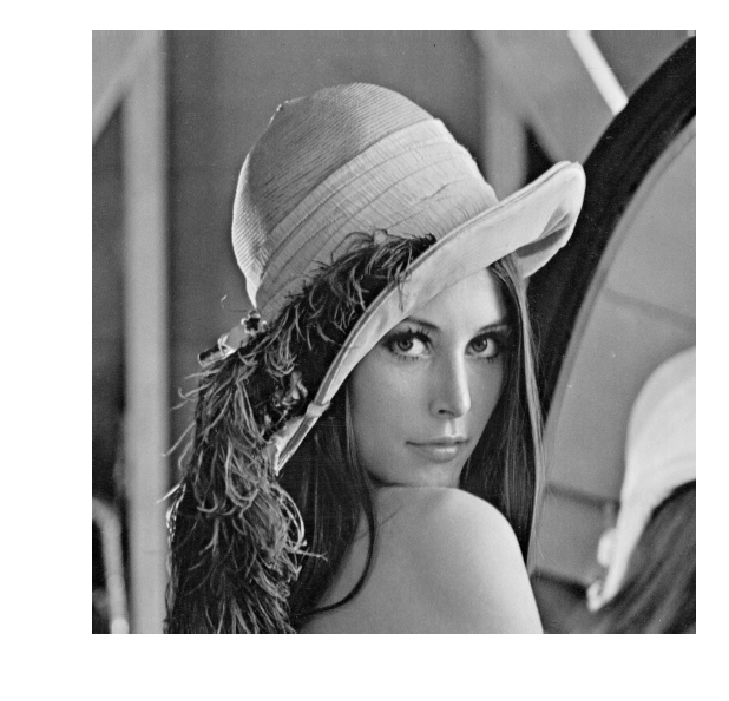

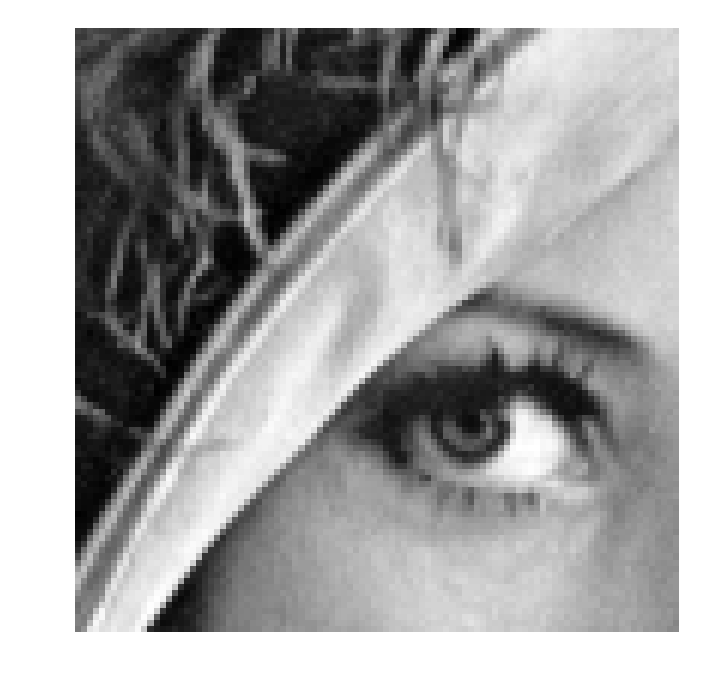

In [44]:
# JPEG2000
_, encoded_im = cv2.imencode('.jp2', orig_im)
decoded_im = cv2.imdecode(encoded_im, 0)

buf_size_b = encoded_im.shape[0] * 8 # uint8 data type in buffer

print('JPEG2000 encoded image')
print('Buffer data type: {}'.format(encoded_im.dtype))
print('Buffer shape: {}'.format(encoded_im.shape))
print('Compression rate: {0:.2f}'.format
      (orig_size_b / buf_size_b))

plt.figure(0, dpi=200)
plt.imshow(decoded_im, cmap='gray')
plt.axis('off')

plt.figure(1, dpi=200)
plt.imshow(decoded_im[200:300, 200:300], cmap='gray')
plt.axis('off')